In [ ]:
# pip install urllib3==1.26.15
# pip install scipy==1.12

In [1]:
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.tokenizer = WordPunctTokenizer()
    def preprocess_text(self, text):
        text = text.lower()
        text = emoji.demojize(text)
        text = re.sub(r'[^\w\s]', '', text)
        tokens = self.tokenizer.tokenize(text)
        tokens = [word for word in tokens if word not in self.stop_words and word.isalnum()]
        tokens = [self.lemmatize_token(word) for word in tokens]
        return " ".join(tokens)

    def lemmatize_token(self, token):
        tag = self.get_wordnet_pos(nltk.pos_tag([token])[0][1])
        return self.lemmatizer.lemmatize(token, pos=tag) if tag else token
    @staticmethod
    def get_wordnet_pos(treebank_tag):
        #Converts treebank tag to wordnet tag
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None

In [3]:
def preprocess(df, data_type):
    if data_type == 'comments':
        text = 'body'
    elif data_type == 'submissions':
        text = 'selftext'
    col_index = df.columns.get_loc(text) + 1
    preprocessed_text = df[text].apply(preprocessor.preprocess_text)
    df.insert(col_index, 'preprocessed_txt', preprocessed_text)
    return df

In [4]:
import pandas as pd
combined_male_comments = pd.read_csv("/home/haters/Downloads/loaded_data/Combined_data_29Apr/combined_male_comments.csv")

/tmp/ipykernel_4725/805374691.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_male_comments = pd.read_csv("/home/haters/Downloads/loaded_data/Combined_data_29Apr/combined_male_comments.csv")


In [5]:
preprocessor = TextPreprocessor()
combined_male_comments = preprocess(combined_male_comments, 'comments')
combined_male_comments.head(10)

,body,preprocessed_txt,subreddit,link_id,retrieved_on,artist,temp_id
0,"This song is fucking magic live, when the crow...",song fuck magic live crowd sings japanese part...,BadBunnyPR,t3_za73lr,2023-01-08 06:20:57,Bad Bunny,NaN
1,WOW Top 0.05%!! My gf was 0.1% and I thought T...,wow top 005 gf 01 thought elite im top 05,BadBunnyPR,t3_z9wmhw,2023-01-08 06:19:27,Bad Bunny,NaN
2,Dude same omg \nI cant find the right mix any...,dude omg cant find right mix anywhere,BadBunnyPR,t3_xm3rmh,2023-01-08 06:18:20,Bad Bunny,NaN
3,I’m proud to say that I’m top 0.01 percent,im proud say im top 001 percent,BadBunnyPR,t3_z9wmhw,2023-01-08 06:17:58,Bad Bunny,NaN
4,I had that in 2019,2019,BadBunnyPR,t3_zad5e3,2023-01-08 06:16:46,Bad Bunny,NaN
5,Holyyy shit. I thought my top 1% was good. Lmao.,holyyy shit thought top 1 good lmao,BadBunnyPR,t3_zad5e3,2023-01-08 06:15:39,Bad Bunny,NaN
6,Jesus Christ. I’ve never seen anyone with a .0...,jesus christ ive never see anyone 01 artist yo...,BadBunnyPR,t3_zad5e3,2023-01-08 06:15:10,Bad Bunny,NaN
7,"Bruv I have 49k total on Spotify this year, yo...",bruv 49k total spotify year single artist,BadBunnyPR,t3_z96g7v,2023-01-08 06:12:48,Bad Bunny,NaN
8,A friend of mine had around 145k minutes,friend mine around 145k minute,BadBunnyPR,t3_zad5e3,2023-01-08 06:03:29,Bad Bunny,NaN
9,Same 🥹,,BadBunnyPR,t3_zad5e3,2023-01-08 06:02:02,Bad Bunny,NaN


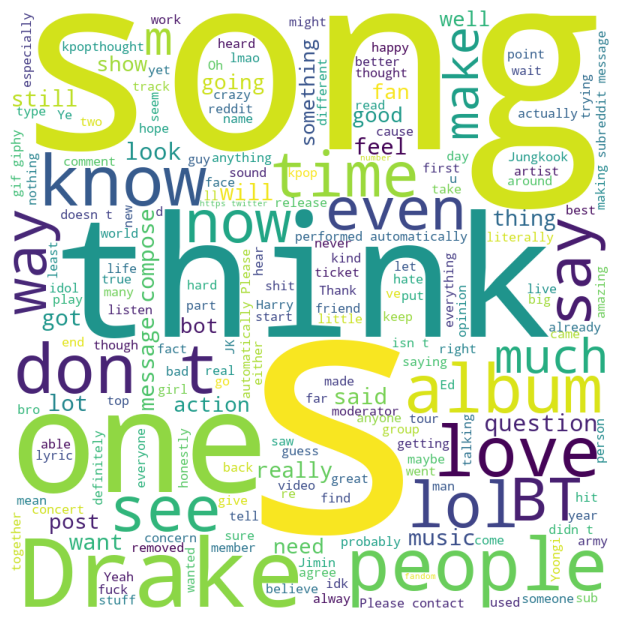

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(text):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(text) 
    plt.figure(figsize = (6, 6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()
    
text = ' '.join(combined_male_comments['body'])
plot_wordcloud(text)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def lda_topic_modeling(text, num_topics):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words = 'english')
    data_vectorized = vectorizer.fit_transform(text)
    lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=10, learning_method='online', random_state=100, n_jobs=-1)
    lda_output = lda_model.fit_transform(data_vectorized)
    return lda_model, lda_output, vectorizer
num_topics = 5
lda_model, lda_output, vectorizer = lda_topic_modeling(combined_male_comments['preprocessed_txt'].apply(lambda x: ' '.join(x)), num_topics)

In [8]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
no_top_words = 10
display_topics(lda_model, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
lol fuck yeah army jimin thank dude list whats wish
Topic 1:
music post love question perform title automatically comment bot action
Topic 2:
song like album really look good feel thats listen doesnt
Topic 3:
drake make want big sure say man start release im
Topic 4:
dont people like im say think time know year fan


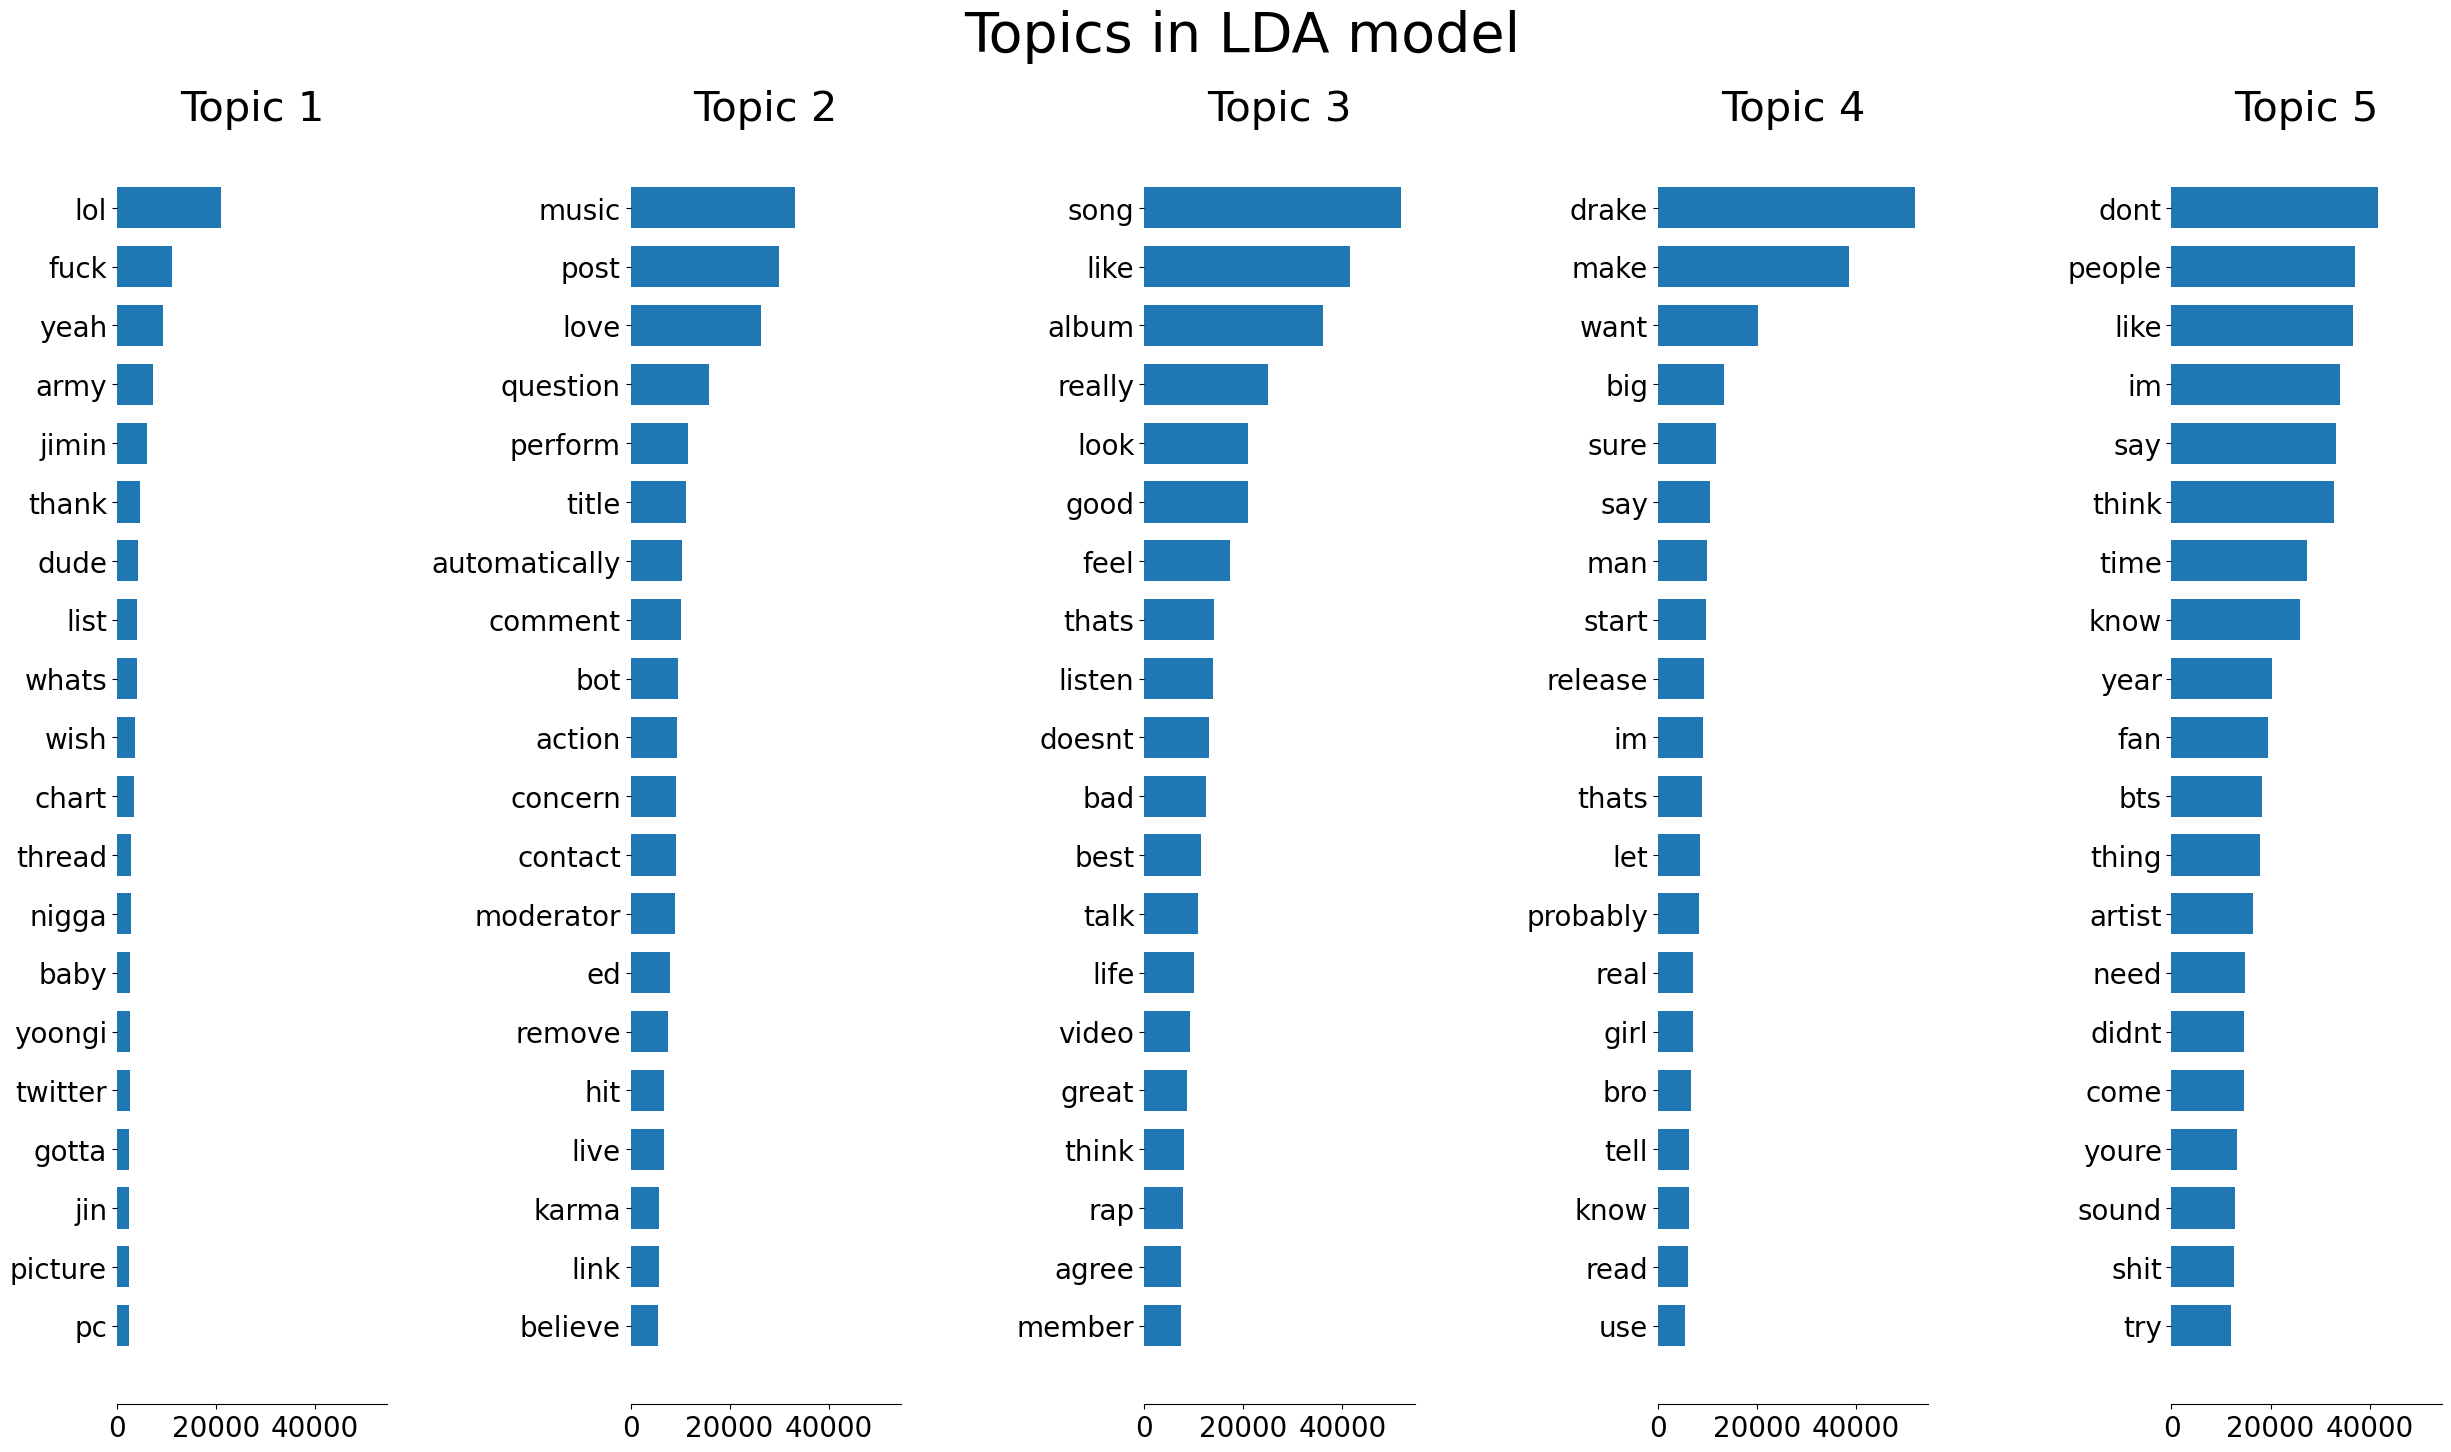

In [9]:
import matplotlib.pyplot as plt
def plot_top_words(lda_model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(lda_model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                      fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
n_top_words = 20
plot_top_words(lda_model, vectorizer.get_feature_names_out(), n_top_words, 'Topics in LDA model')

In [12]:
import pyLDAvis.gensim_models
from gensim import corpora
from gensim.models.ldamodel import LdaModel

def lda_topic_modeling_gensim(text, num_topics):
    dictionary = corpora.Dictionary(text)
    corpus = [dictionary.doc2bow(doc) for doc in text]
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
    return lda_model, corpus, dictionary

num_topics = 5
lda_model_gensim, corpus, dictionary = lda_topic_modeling_gensim(combined_male_comments['preprocessed_txt'], num_topics)

In [13]:
pyLDAvis.enable_notebook()
pyLDAvis_display = pyLDAvis.gensim_models.prepare(lda_model_gensim, corpus, dictionary)
pyLDAvis_display

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.072537 -0.412855       1        1  51.917276
2     -0.169324  0.070896       2        1  15.989699
3     -0.116342  0.122093       3        1  11.632232
0      0.396601  0.166350       4        1  10.610224
1     -0.183471  0.053516       5        1   9.850569, topic_info=           Term          Freq         Total Category  logprob  loglift
7          song  49144.000000  49144.000000  Default  30.0000  30.0000
93        music  40529.000000  40529.000000  Default  29.0000  29.0000
660        post  38865.000000  38865.000000  Default  28.0000  28.0000
255       album  38918.000000  38918.000000  Default  27.0000  27.0000
2518      title  28803.000000  28803.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
659         100   4586.640590   4710.454021   Topic5  -4.8663   2.2910
28737     jimin   9531.135699  11085.623437   Topic5  -4.1349   2.1666
2086   shipping   6833.093095   8670.541110   Topic5  -4.4677   2.0795
1776        bts  20012.672705  48726.969382   Topic5  -3.3931   1.4278
28724  jungkook   7868.001080  15227.720553   Topic5  -4.3267   1.6573

[197 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
659       4  0.026112    100
659       5  0.973791    100
330       3  0.999901      4
1041      5  0.999946      5
981       5  0.999803      6
...     ...       ...    ...
94        3  0.999922   yeah
49        2  0.999959   year
114       4  0.999880    yes
369       5  0.999979    yet
43        1  0.999957  youre

[190 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 1, 2])

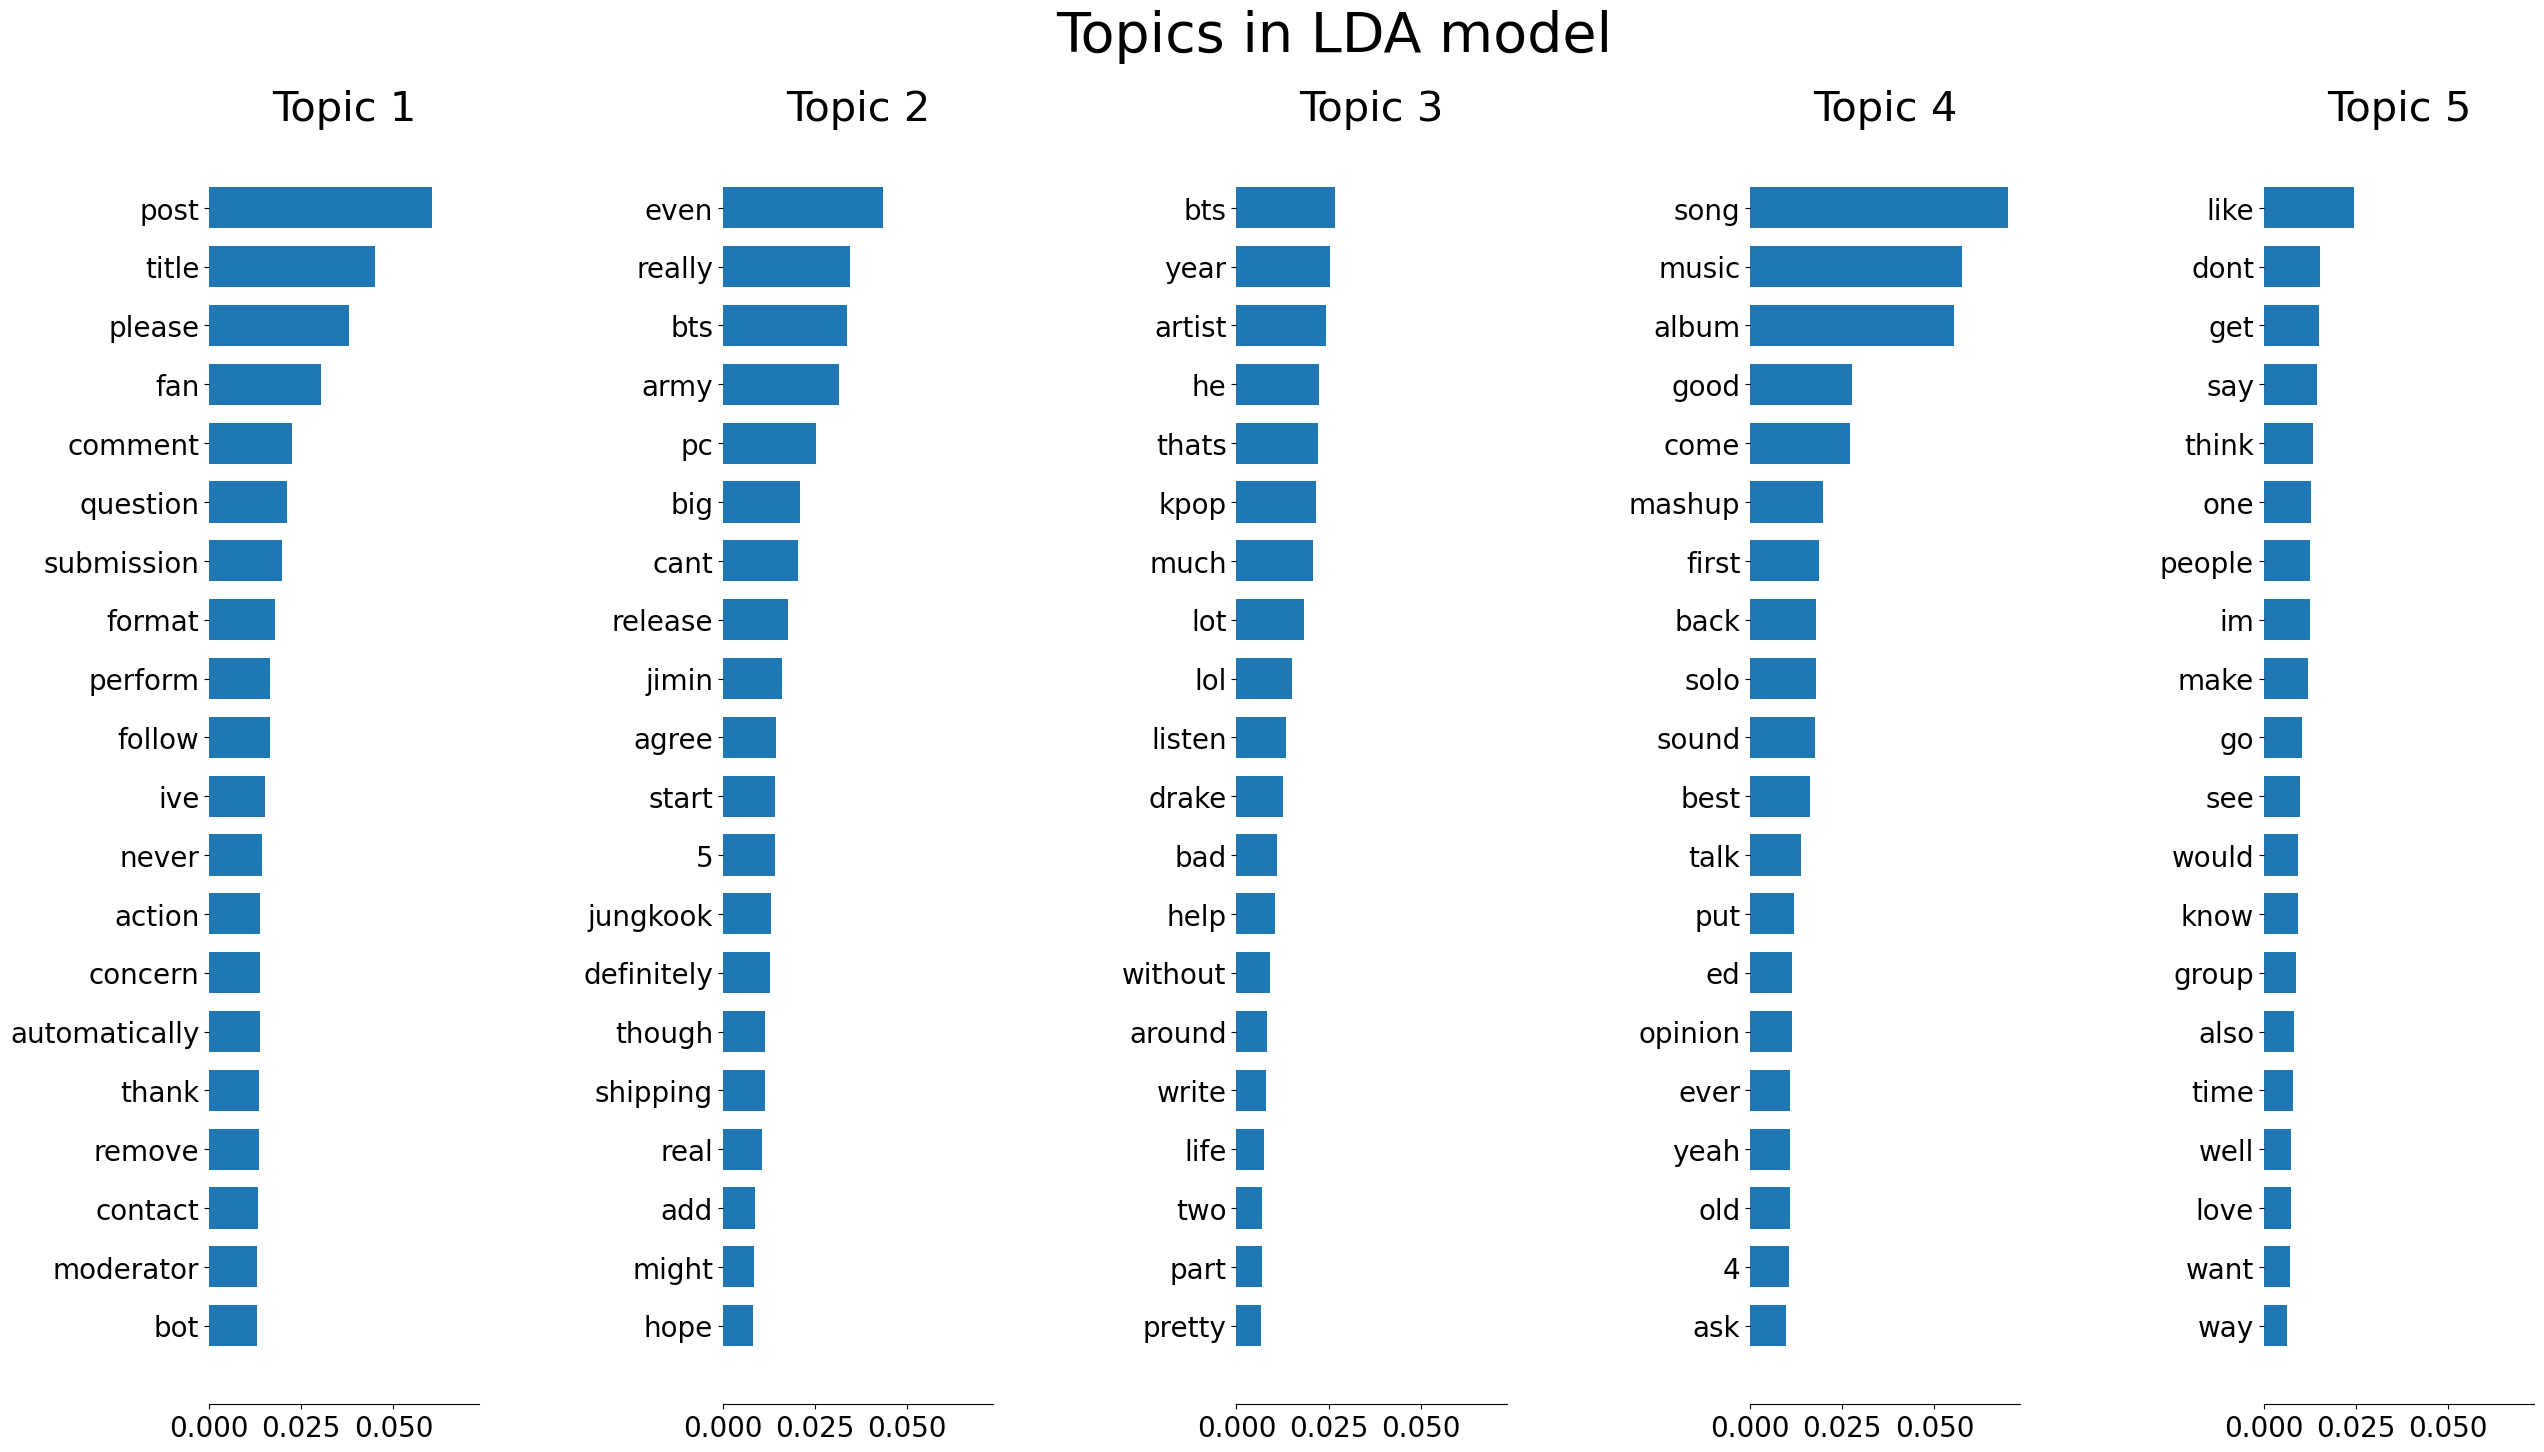

In [14]:
import matplotlib.pyplot as plt

def plot_top_words_gensim(lda_model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    topics = lda_model.get_topics()
    for topic_idx, topic in enumerate(topics):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                      fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
plot_top_words_gensim(lda_model_gensim, dictionary, n_top_words, 'Topics in LDA model')

In [17]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from guidedlda import GuidedLDA

def guided_lda_topic_modeling(text, num_topics, seed_topic_list, seed_confidence):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    data_vectorized = vectorizer.fit_transform(text)
    vocab = vectorizer.get_feature_names_out()
    word2id = dict((v, idx) for idx, v in enumerate(vocab))

    # Seed topics
    seed_topics = {}
    for t_id, st in enumerate(seed_topic_list):
        for word in st:
            seed_topics[word2id[word]] = t_id

    model = GuidedLDA(n_topics=num_topics, n_iter=100, random_state=7, refresh=20)
    model.fit(data_vectorized, seed_topics=seed_topics, seed_confidence=seed_confidence)

    return model, data_vectorized, vectorizer

seed_topic_list = [['performance'], ['outlook'], ['daily', 'life']]  # seed words for each topic
seed_confidence = 0.15  # The confidence in the seeded topics. A higher value means the seed words have more influence

num_topics = 3
guided_lda_model, data_vectorized, vectorizer = guided_lda_topic_modeling(combined_male_comments['preprocessed_txt'].apply(lambda x: ' '.join(x)), num_topics, seed_topic_list, seed_confidence)

ModuleNotFoundError: No module named 'guidedlda'

In [2]:
from guidedlda import GuidedLDA

ModuleNotFoundError: No module named 'guidedlda'

In [3]:
pip install guidedlda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.7 MB/s eta 0:00:0031m11.2 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [168 lines of output]
      /opt/anaconda3/lib/python3.11/site-packages/setuptools/dist.py:498: SetuptoolsDeprecationWarning: Invalid dash-separated options
      !!
      
              ********************************************************************************
              Usage of dash-separated 'description-file' will not be supported in future
              versions. Please use the underscore name 'description_file' instead.
      
              This deprecation is overdue, please update your project and remove deprecated
              calls to avoid build errors in the future.
      
              See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
              ***************

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(combined_male_comments["body"])

In [ ]:
topic_model.get_topic_info()

In [7]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['OMP_NESTED'] = 'TRUE'
os.environ['OMP_MAX_ACTIVE_LEVELS'] = '2'

In [8]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

# Fine-tune your topic representations
representation_model = KeyBERTInspired()
topic_model = BERTopic(representation_model=representation_model)

In [9]:
import openai
from bertopic.representation import OpenAI

client = openai.OpenAI(api_key="sk-proj-gG6FGWe4cnZTkC7yXs6vT3BlbkFJJzuYJYPdMejwj7x3JIBa")
representation_model = OpenAI(client, model="gpt-3.5-turbo", chat=True)
topic_model = BERTopic(representation_model=representation_model)

In [10]:
combined_male_comments.head()

,body,preprocessed_txt,subreddit,link_id,retrieved_on,artist,temp_id
0,"This song is fucking magic live, when the crow...",song fuck magic live crowd sings japanese part...,BadBunnyPR,t3_za73lr,2023-01-08 06:20:57,Bad Bunny,NaN
1,WOW Top 0.05%!! My gf was 0.1% and I thought T...,wow top 005 gf 01 thought elite im top 05,BadBunnyPR,t3_z9wmhw,2023-01-08 06:19:27,Bad Bunny,NaN
2,Dude same omg \nI cant find the right mix any...,dude omg cant find right mix anywhere,BadBunnyPR,t3_xm3rmh,2023-01-08 06:18:20,Bad Bunny,NaN
3,I’m proud to say that I’m top 0.01 percent,im proud say im top 001 percent,BadBunnyPR,t3_z9wmhw,2023-01-08 06:17:58,Bad Bunny,NaN
4,I had that in 2019,2019,BadBunnyPR,t3_zad5e3,2023-01-08 06:16:46,Bad Bunny,NaN


In [11]:
topics, probs = topic_model.fit_transform(combined_male_comments["preprocessed_txt"])

In [12]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,184273,-1_Analysis of BTS members' solo endeavors and...,[Analysis of BTS members' solo endeavors and i...,[dont see member leave anywhere soon maybe eve...
1,0,7814,0_Extraction of documents using keywords and d...,[Extraction of documents using keywords and de...,"[, , ]"
2,1,2731,1_Yoongi and his diverse interests and connect...,[Yoongi and his diverse interests and connecti...,"[yoongi, yoongi, yoongi]"
3,2,1680,2_gifgiphy topic with various images,[gifgiphy topic with various images],"[gifgiphyl4hnkwijjajqb04zq, gifgiphyl4hnkwijja..."
4,3,1445,3_Harry Styles and One Direction's World,[Harry Styles and One Direction's World],"[harry, harry, harry]"
...,...,...,...,...,...
5333,5332,10,5332_Fanbase Dynamics and Support in the Fando...,[Fanbase Dynamics and Support in the FandomArmy],[really excite read lenikas long form work bts...
5334,5333,10,5333_Military Enlistments and Speculations of ...,[Military Enlistments and Speculations of K-Po...,[wait whattt jin jh get military get ready per...
5335,5334,10,5334_Haciendo Que Amas,[Haciendo Que Amas],"[haciendo que amas, haciendo que amas, haciend..."
5336,5335,10,5335_Spotify account spam and archivist love m...,[Spotify account spam and archivist love musings],"[lol yes shame apart 0005 listener spotify, 00..."


In [13]:
topic_model.get_document_info(combined_male_comments["preprocessed_txt"])

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,song fuck magic live crowd sings japanese part...,-1,-1_Analysis of BTS members' solo endeavors and...,[Analysis of BTS members' solo endeavors and i...,[dont see member leave anywhere soon maybe eve...,Analysis of BTS members' solo endeavors and im...,0.000000,False
1,wow top 005 gf 01 thought elite im top 05,34,34_Top 5 Documents and Keywords,[Top 5 Documents and Keywords],"[top 5 top 5, top 5, top 5]",Top 5 Documents and Keywords,0.572754,False
2,dude omg cant find right mix anywhere,1853,1853_Mix and Mixing Production,[Mix and Mixing Production],"[probably mix, dont like mix, mix]",Mix and Mixing Production,0.675103,False
3,im proud say im top 001 percent,2827,2827_Proud Listener,[Proud Listener],"[im proud, im proud, im proud]",Proud Listener,0.899533,False
4,2019,2709,2709_2018 Bboom Momolands Year 2016 15 Id Anyt...,[2018 Bboom Momolands Year 2016 15 Id Anything...,"[2018, 2018, 2018]",2018 Bboom Momolands Year 2016 15 Id Anything ...,0.447518,False
...,...,...,...,...,...,...,...,...
458941,good look drake satanic puppet many sexual ass...,-1,-1_Analysis of BTS members' solo endeavors and...,[Analysis of BTS members' solo endeavors and i...,[dont see member leave anywhere soon maybe eve...,Analysis of BTS members' solo endeavors and im...,0.000000,False
458942,heard creepy thing well agree see morgan diffe...,98,98_morgan wallen controversy,[morgan wallen controversy],"[morgan wallen lol, morgan wallen x drake, mor...",morgan wallen controversy,1.000000,False
458943,satanic puppet even mean,570,570_demons and satanic themes,[demons and satanic themes],"[demon demon demon, demon, demon]",demons and satanic themes,0.295353,False
458944,agree im afraid morgan get use easily big hear...,98,98_morgan wallen controversy,[morgan wallen controversy],"[morgan wallen lol, morgan wallen x drake, mor...",morgan wallen controversy,0.545759,False


In [6]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['OMP_NUM_THREADS'] = '4'
# os.environ['OMP_NESTED'] = 'TRUE'
os.environ['OMP_MAX_ACTIVE_LEVELS'] = '2'

In [25]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.representation import OpenAI, KeyBERTInspired
from sentence_transformers import SentenceTransformer
import openai

class CombinedModel:
    def __init__(self, openai_model, keybert_model):
        self.openai_model = openai_model
        self.keybert_model = keybert_model

    def transform(self, documents):
        # Use the GPT-3.5 Turbo model to transform the text data into embeddings
        embeddings1 = self.openai_model.transform(documents)

        # Use the KeyBERTInspired model to further transform these embeddings
        embeddings2 = self.keybert_model.transform(embeddings1)

        return embeddings2



client = openai.OpenAI(api_key="sk-proj-gG6FGWe4cnZTkC7yXs6vT3BlbkFJJzuYJYPdMejwj7x3JIBa")
gpt3_model = OpenAI(client, model="gpt-3.5-turbo", chat=True)
keybert_model = KeyBERTInspired()
combined_model = CombinedModel(gpt3_model, keybert_model)


umap_model = UMAP(n_neighbors=5, n_components=5, min_dist=0.05, metric = "cosine")
hdbscan_model = HDBSCAN(min_cluster_size=800, min_samples=400,
                        gen_min_span_tree=True,
                        prediction_data=True)

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stopwords = list(stopwords.words('english'))

# we add this to remove stopwords that can pollute topcs
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=stopwords)

In [27]:
from bertopic import BERTopic

model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=combined_model,
    vectorizer_model=vectorizer_model,
    top_n_words=10,
    language='english',
    calculate_probabilities=True,
    verbose=True
)

topics, probs = model.fit_transform(combined_male_comments["preprocessed_txt"])

2024-06-28 14:58:45,041 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/14343 [00:00<?, ?it/s]

2024-06-28 15:00:38,569 - BERTopic - Embedding - Completed ✓
2024-06-28 15:00:38,570 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-28 15:12:25,112 - BERTopic - Dimensionality - Completed ✓
2024-06-28 15:12:25,117 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-28 15:15:42,750 - BERTopic - Cluster - Completed ✓
2024-06-28 15:15:42,788 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-28 15:15:57,273 - BERTopic - Representation - Completed ✓


In [28]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,273493,-1_like_get_im_post,"[like, get, im, post, song, one, please, go, s...",[hello uughbadbye contribution rkpopthoughts a...
1,0,40021,0_drake_rap_like_drake type,"[drake, rap, like, drake type, type, say, albu...","[drake type guy, drake, w drake]"
2,1,16635,1_bts_kpop_group_army,"[bts, kpop, group, army, fan, people, like, fa...",[even quote part ops post irk explain people m...
3,2,16212,2_album_song_love_like,"[album, song, love, like, ed, listen, lyric, o...",[amaze experience wife still disbelief awe mor...
4,3,6419,3_tour_concert_show_stadium,"[tour, concert, show, stadium, go, stage, tick...",[go show seattle 4 stadium show one go subtrac...
5,4,5830,4_look_pic_eye_photo,"[look, pic, eye, photo, cute, smile, picture, ...","[look, look, look]"
6,5,5815,5____,"[, , , , , , , , , ]","[, , ]"
7,6,5765,6_pc_shipping_merch_shirt,"[pc, shipping, merch, shirt, wear, sell, price...",[bts bts festa 8th anniversary calendar full s...
8,7,5180,7_jimin_jimins_jungkook_song,"[jimin, jimins, jungkook, song, like, im, solo...","[jimin look good, jimin, jimin x jimin straigh..."
9,8,4854,8_cum_cum cum_hand_drink,"[cum, cum cum, hand, drink, kiss, lip, taste, ...",[pull let cum fall nina pussy join nina juice ...


In [29]:
model.get_topic_info()['Name'].tolist()

['-1_like_get_im_post',
 '0_drake_rap_like_drake type',
 '1_bts_kpop_group_army',
 '2_album_song_love_like',
 '3_tour_concert_show_stadium',
 '4_look_pic_eye_photo',
 '5____',
 '6_pc_shipping_merch_shirt',
 '7_jimin_jimins_jungkook_song',
 '8_cum_cum cum_hand_drink',
 '9_ticket_seat_ticketmaster_sell',
 '10_music_artist_country_like',
 '11_harry_louis_larry_harrys',
 '12_disturb_gif_disturb disturb_gifgiphycl4pqu8ggriihabgsmdownsized',
 '13_page_post_gt_trans',
 '14_bunny_bad bunny_bad_spanish',
 '15_yoongi_min yoongi_min_yoongis',
 '16_que_de_la_el',
 '17_video_watch_episode_movie',
 '18_joke_sub_laugh_funny',
 '19_talk_mean_bro_say',
 '20_old_age_year old_mom',
 '21_cry_miss_tear_hope',
 '22_drop_time_week_month',
 '23_shes_together_relationship_date',
 '24_ai_chord_copyright_progression',
 '25_aubrey_aubrey aubrey_elizabeth_graham',
 '26_skull_skullskullskull_skull skull_skullskull',
 '27_taylor_swift_taylor swift_beyoncé',
 '28_concern post_moderator subredditmessagecomposetordrake

In [30]:
model.get_document_info(combined_male_comments["preprocessed_txt"])

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,song fuck magic live crowd sings japanese part...,2,2_album_song_love_like,"[album, song, love, like, ed, listen, lyric, o...",[amaze experience wife still disbelief awe mor...,album - song - love - like - ed - listen - lyr...,0.111633,False
1,wow top 005 gf 01 thought elite im top 05,50,50_top_top 10_top top_10,"[top, top 10, top top, 10, rank, even top, og,...","[top 2, top 2 he 2, top 5]",top - top 10 - top top - 10 - rank - even top ...,1.000000,False
2,dude omg cant find right mix anywhere,-1,-1_like_get_im_post,"[like, get, im, post, song, one, please, go, s...",[hello uughbadbye contribution rkpopthoughts a...,like - get - im - post - song - one - please -...,0.840473,False
3,im proud say im top 001 percent,-1,-1_like_get_im_post,"[like, get, im, post, song, one, please, go, s...",[hello uughbadbye contribution rkpopthoughts a...,like - get - im - post - song - one - please -...,0.983650,False
4,2019,-1,-1_like_get_im_post,"[like, get, im, post, song, one, please, go, s...",[hello uughbadbye contribution rkpopthoughts a...,like - get - im - post - song - one - please -...,0.935228,False
...,...,...,...,...,...,...,...,...
458941,good look drake satanic puppet many sexual ass...,-1,-1_like_get_im_post,"[like, get, im, post, song, one, please, go, s...",[hello uughbadbye contribution rkpopthoughts a...,like - get - im - post - song - one - please -...,0.682381,False
458942,heard creepy thing well agree see morgan diffe...,-1,-1_like_get_im_post,"[like, get, im, post, song, one, please, go, s...",[hello uughbadbye contribution rkpopthoughts a...,like - get - im - post - song - one - please -...,0.682381,False
458943,satanic puppet even mean,-1,-1_like_get_im_post,"[like, get, im, post, song, one, please, go, s...",[hello uughbadbye contribution rkpopthoughts a...,like - get - im - post - song - one - please -...,0.925970,False
458944,agree im afraid morgan get use easily big hear...,0,0_drake_rap_like_drake type,"[drake, rap, like, drake type, type, say, albu...","[drake type guy, drake, w drake]",drake - rap - like - drake type - type - say -...,0.308020,False


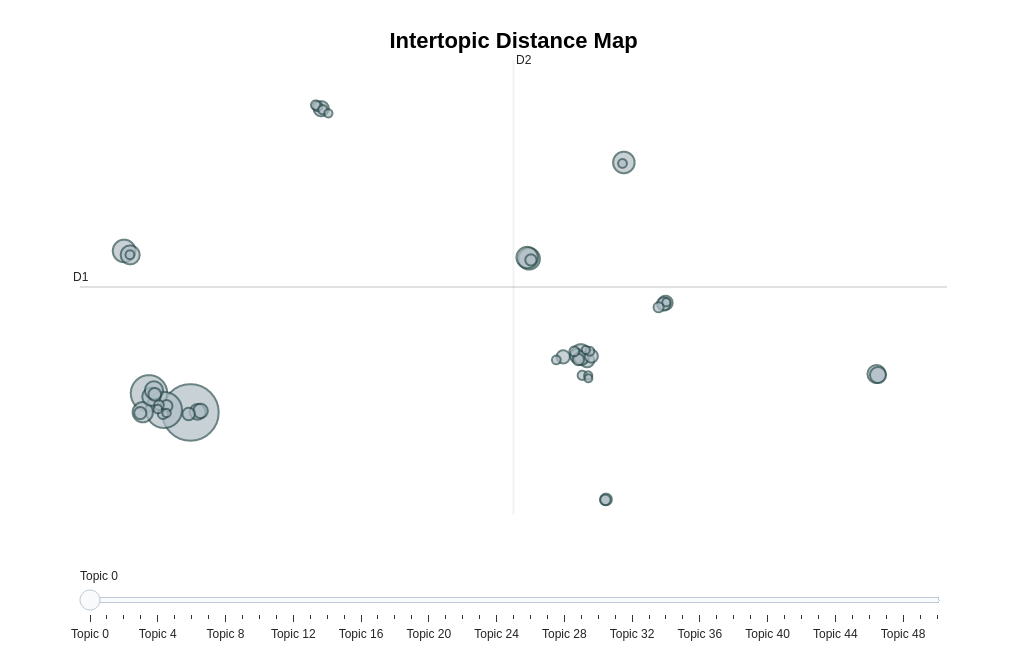

In [31]:
fig1 = model.visualize_topics()
fig1.show()

In [19]:
temp = model.get_document_info(combined_male_comments["preprocessed_txt"])

In [21]:
temp["Topic"].value_counts()

Topic
 0    373103
-1     70631
 1      6085
 2      3388
 3      2530
 4      1380
 5       918
 6       911
Name: count, dtype: int64

In [22]:
combined_male_comments.shape

(458946, 7)

In [16]:
temp_2 = temp[temp["Probability"] > 0.5]

In [17]:
temp_2

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,song fuck magic live crowd sings japanese part...,-1,-1_song_like_album_think,"[song, like, album, think, people]",[please remember adhere rule 1 stay topic 2 re...,song - like - album - think - people,0.514553,False
3,im proud say im top 001 percent,476,476_im proud_way sexy_sexy_pride,"[im proud, way sexy, sexy, pride, proud]","[way 2 sexy, way 2 sexy, way 2 sexy]",im proud - way sexy - sexy - pride - proud,1.000000,False
9,,-1,-1_song_like_album_think,"[song, like, album, think, people]",[please remember adhere rule 1 stay topic 2 re...,song - like - album - think - people,0.750351,True
15,shit come benefit besides music yeah,-1,-1_song_like_album_think,"[song, like, album, think, people]",[please remember adhere rule 1 stay topic 2 re...,song - like - album - think - people,0.529091,False
18,early access shoe well yes,100,100_order_ship_email_shipping,"[order, ship, email, shipping, shoe]",[heard back customer support want share receiv...,order - ship - email - shipping - shoe,1.000000,False
...,...,...,...,...,...,...,...,...
458935,music video,169,169_music video_video_love video_music,"[music video, video, love video, music, video ...","[music video, he music video, music video]",music video - video - love video - music - vid...,1.000000,True
458936,broke heart,-1,-1_song_like_album_think,"[song, like, album, think, people]",[please remember adhere rule 1 stay topic 2 re...,song - like - album - think - people,0.553547,False
458937,amaze cameo even doesnt make end video even mi...,99,99_amaze_amaze amaze_amaze wow_weak,"[amaze, amaze amaze, amaze wow, weak, wow amaze]","[amaze, amaze, amaze]",amaze - amaze amaze - amaze wow - weak - wow a...,1.000000,False
458940,agree already think might sell,487,487_sell sell_sell_sale_buy,"[sell sell, sell, sale, buy, money sex]","[sell, sell, sell]",sell sell - sell - sale - buy - money sex,1.000000,False


In [15]:
temp.to_csv('temp.csv')

In [19]:
temp_2.to_csv('temp_2_filtered.csv')